In [2]:
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
genres = os.listdir("../data/genres_original")
genres.sort()

In [ ]:
genre_file_counts = {}
total_files = 0

for genre in genres:
    genre_path = os.path.join("../data/genres_original", genre)
    
    files = [f for f in os.listdir(genre_path) if f.endswith('.wav')]
    count = len(files)  
    genre_file_counts[genre] = count
    total_files += count
    
    print(f"{genre:15} : {count:3} files")


blues           : 100 files
classical       : 100 files
country         : 100 files
disco           : 100 files
hiphop          : 100 files
jazz            : 100 files
metal           : 100 files
pop             : 100 files
reggae          : 100 files
rock            : 100 files


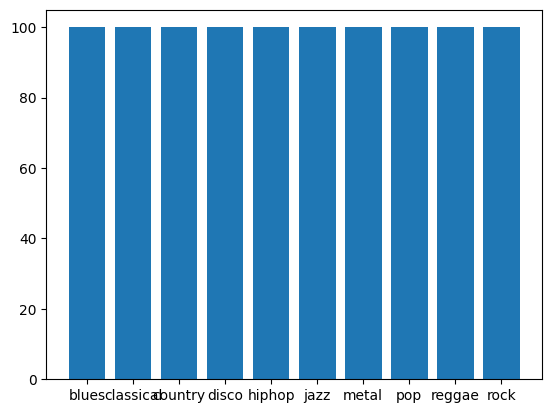